# Analisis de conector.

In [15]:
# Cargar librerias.
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os

In [16]:
IMG_SIZE = 128

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=1),

    # Data Augmentation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),

    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [17]:
ruta_dataset_train = 'datasets_piezas_te/2p_workshop/train'
ruta_dataset_test = 'datasets_piezas_te/2p_workshop/test'

try:
    train_dataset = datasets.ImageFolder(
        root=ruta_dataset_train,
        transform=train_transforms
    )
    
    test_dataset = datasets.ImageFolder(
        root=ruta_dataset_test,
        transform=test_transforms
    )

    print(f"Dataset cargado exitosamente")
    print(f"Clases encontradas: {train_dataset.classes}")
    print(f" (0: {train_dataset.classes[0]}, 1: {train_dataset.classes[1]})")
    print(f"Imágenes de entrenamiento: {len(train_dataset)}")
    print(f"Imágenes de prueba: {len(test_dataset)}")

except FileNotFoundError:
    print("¡ERROR! No se encontró la ruta del dataset.")
    print("Por favor, asegúrate de que la variable 'ruta_dataset_train' y 'ruta_dataset_test' sean correctas")
    print("Y que tu estructura sea: ./dataset_conectores/train/OK, ./dataset_conectores/train/NG, etc.")

Dataset cargado exitosamente
Clases encontradas: ['ng', 'ok']
 (0: ng, 1: ok)
Imágenes de entrenamiento: 796
Imágenes de prueba: 196


In [18]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"DataLoaders creados con tamaño de lote {BATCH_SIZE}")



DataLoaders creados con tamaño de lote 32


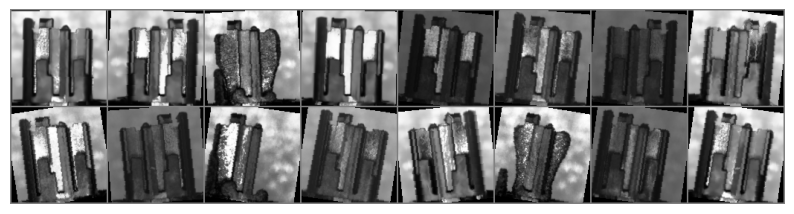

Etiquetas (labels): ok    ok    ng    ok    ok    ok    ok    ok    ok    ok    ng    ok    ok    ng    ok    ok   


In [19]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)).squeeze(), cmap='gray')
    plt.axis('off')

dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(10,6))
imshow(torchvision.utils.make_grid(images[:16]))
plt.show()

print('Etiquetas (labels):', ' '.join(f'{train_dataset.classes[labels[j]]:5s}' for j in range(16)))



Definir la arquitectura de la CNN

In [20]:
class CNN_Conectores(nn.Module):

    def __init__(self):
        super(CNN_Conectores, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)

        self.relu = nn.ReLU()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=32 * 32 * 32, out_features=128)

        self.fc2 = nn.Linear(in_features=128, out_features=2)

    def forward(self, x):

        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

Instancia del modelo.

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNN_Conectores()

model.to(device)

print(F"Modelo creado y movido exitosamente a: {device}")

print(model)

Modelo creado y movido exitosamente a: cpu
CNN_Conectores(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


## Entrenamiento

In [22]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Función de Pérdida (CrossEntropy) y Optimizador (Adam) definidos")

Función de Pérdida (CrossEntropy) y Optimizador (Adam) definidos


Bucle de entrenamiento

In [24]:
num_epochs = 10

print("Comenzando el entrenamiento...")

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        if i % 10 == 9:
            print(f'[Época {epoch+1}, Lote {i+1}] Loss: {running_loss / 10:.3f}')
            running_loss = 0.0

print('Entrenamiento finalizado')

Comenzando el entrenamiento...
[Época 1, Lote 10] Loss: 0.779
[Época 1, Lote 20] Loss: 0.228
[Época 2, Lote 10] Loss: 0.019
[Época 2, Lote 20] Loss: 0.011
[Época 3, Lote 10] Loss: 0.020
[Época 3, Lote 20] Loss: 0.002
[Época 4, Lote 10] Loss: 0.001
[Época 4, Lote 20] Loss: 0.000
[Época 5, Lote 10] Loss: 0.000
[Época 5, Lote 20] Loss: 0.001
[Época 6, Lote 10] Loss: 0.002
[Época 6, Lote 20] Loss: 0.002
[Época 7, Lote 10] Loss: 0.000
[Época 7, Lote 20] Loss: 0.003
[Época 8, Lote 10] Loss: 0.000
[Época 8, Lote 20] Loss: 0.000
[Época 9, Lote 10] Loss: 0.000
[Época 9, Lote 20] Loss: 0.000
[Época 10, Lote 10] Loss: 0.000
[Época 10, Lote 20] Loss: 0.000
Entrenamiento finalizado


## Evaluación

In [25]:
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)

        correct += (predicted == labels).sum().item()

accuracy = 100 * correct /total

print(f'Evaluación finalizada')
print(f'Precisión (Accuracy) del modelo en el set de prueba: {accuracy:.2f} %')


Evaluación finalizada
Precisión (Accuracy) del modelo en el set de prueba: 100.00 %


In [27]:
from PIL import Image

ruta_imagen_desafio = 'datasets_piezas_te/2p_workshop/test/NG/img_000_20221124_103618_248.png'
clases = train_dataset.classes

try:
    img = Image.open(ruta_imagen_desafio)

    img_tensor = test_transforms(img)

    img_tensor = img_tensor.unsqueeze(0)

    img_tensor = img_tensor.to(device)

    model.eval()
    with torch.no_grad():
        output = model(img_tensor)

    _, predicted_idx = torch.max(output.data, 1)

    prediccion_clase = clases[predicted_idx.item()]

    print(f"Prueba de desafio")
    print(f"Imagen: {ruta_imagen_desafio}")
    print(f"Predicción del modelo: {prediccion_clase}")

except FileNotFoundError:
    print(f"No se encontro la imagen de desafio en: {ruta_imagen_desafio}")

Prueba de desafio
Imagen: datasets_piezas_te/2p_workshop/test/NG/img_000_20221124_103618_248.png
Predicción del modelo: ng
